In [1]:
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
# Adjust path to import modules from src
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
try:
    from src.cosinor_model import CosinorModel
except ImportError:
    print("Error: Could not load CosinorModel from src/. Ensure paths and file names are correct.")
    sys.exit(1)

In [5]:
# --- 2. Define Final Extracted Parameters (Manual Input from main.py Output) ---
TAU_FFT = 24.0000 
M_FIT = 75.07
A_RAW = -5.04      # The raw Amplitude value found by curve_fit 
PHI_FIT_RAD = -2.162 # The raw Phase angle (in radians) extracted from the model 
ACROPHASE_CORRECTED = 12.34 # The final, corrected peak time (the key result)

A_FINAL = np.abs(A_RAW) # The final, positive Amplitude

In [7]:
# --- 3. Load Filtered Data ---
FILTERED_FILE = '../data/filtered_data.csv' 
RESULTS_DIR = '../results'
try:
    filtered_df = pd.read_csv(FILTERED_FILE, index_col='Timestamp', parse_dates=True)
    Y_filtered = filtered_df['Filtered_Value']
    print(f"Filtered data loaded successfully from: {FILTERED_FILE}")
except FileNotFoundError:
    print(f" Error: File {FILTERED_FILE} not found. Please run main.py first.")
    sys.exit(1)

Filtered data loaded successfully from: ../data/filtered_data.csv


In [9]:
# --- 4. Generate Smoothed Cosinor Fit Curve ---
# Instantiate the CosinorModel to access the cosinor_func
cosinor_instance = CosinorModel(tau=TAU_FFT)

# Time: t in hours since the start of the data
start_time = filtered_df.index.min()
t_hours = (filtered_df.index - start_time).total_seconds() / 3600

# Generate smooth time points for the fitted line
n_points = 500
t_smooth = np.linspace(t_hours.min(), t_hours.max(), n_points)

# Calculate the fitted Y values using the raw parameters (M_FIT, A_RAW, PHI_FIT_RAD)
Y_fitted_smooth = cosinor_instance.cosinor_func(t_smooth, M_FIT, A_RAW, PHI_FIT_RAD)

# Convert smooth time t_smooth back to datetime format for plotting
time_smooth_dt = pd.to_datetime(t_smooth * 3600, unit='s', origin=start_time)

<>:32: SyntaxWarning: invalid escape sequence '\P'
<>:32: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Surface Laptop 3\AppData\Local\Temp\ipykernel_20260\1344978596.py:32: SyntaxWarning: invalid escape sequence '\P'
  """



 Final plot successfully saved to ../results\rhythm_fit_plot.png


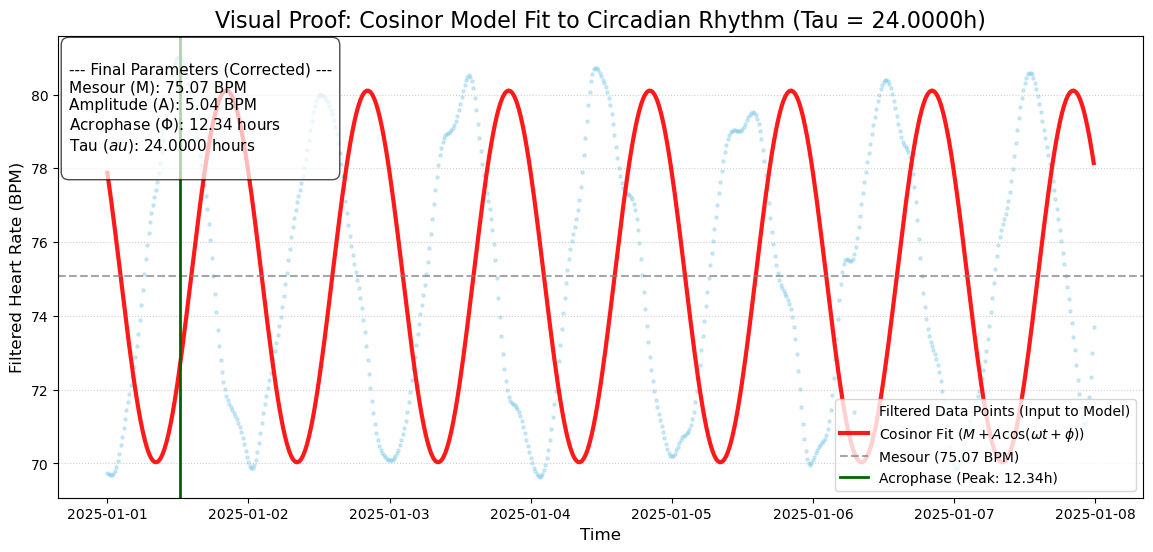

In [11]:
# --- 5. Plotting and Final Save ---

plt.figure(figsize=(14, 6))

# A. Plot Filtered Data (Input to the model)
plt.scatter(filtered_df.index, Y_filtered, 
            label='Filtered Data Points (Input to Model)', 
            s=5, alpha=0.4, color='skyblue')

# B. Plot the Fitted Cosinor Curve (The Model Output)
plt.plot(time_smooth_dt, Y_fitted_smooth, 
         label=r'Cosinor Fit ($M + A \cos(\omega t + \phi)$)', 
         color='red', linewidth=3, alpha=0.9)

# C. Plot Reference Lines and Results Text
# Mesour Line
plt.axhline(M_FIT, color='gray', linestyle='--', alpha=0.7, label=f'Mesour ({M_FIT:.2f} BPM)')

# Acrophase Line (Peak Time)
peak_time_dt = filtered_df.index[0] + pd.Timedelta(hours=ACROPHASE_CORRECTED)
plt.axvline(peak_time_dt, 
            color='darkgreen', linestyle='-', linewidth=2, 
            label=f'Acrophase (Peak: {ACROPHASE_CORRECTED:.2f}h)')

# Add results text to the plot
text_results = f"""
--- Final Parameters (Corrected) ---
Mesour (M): {M_FIT:.2f} BPM
Amplitude (A): {A_FINAL:.2f} BPM
Acrophase ($\Phi$): {ACROPHASE_CORRECTED:.2f} hours
Tau ($\tau$): {TAU_FFT:.4f} hours
"""
plt.text(0.01, 0.98, text_results, transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7))


plt.title(f'Visual Proof: Cosinor Model Fit to Circadian Rhythm (Tau = {TAU_FFT:.4f}h)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Filtered Heart Rate (BPM)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle=':', alpha=0.6)

# Save the final plot to the results folder
os.makedirs(RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(RESULTS_DIR, 'rhythm_fit_plot.png'))
print(f"\n Final plot successfully saved to {os.path.join(RESULTS_DIR, 'rhythm_fit_plot.png')}")
plt.show()